# 목차
## 1. 전체 유저에 대해 문항 번호별로 정답률의 차이가 있는가?
## 2. 유저별로 푼 카테고리의 분포가 다른가? 분포상의 차이가 있는가?
## 3. 출제되는 cat의 특정 조합만 나오는 것인가?
## 4. 결론

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [94]:
train = pd.read_csv('data/train_data.csv')
test = pd.read_csv('data/test_data.csv')

# 1. 전체 유저에 대해 문항 번호별로 정답률의 차이가 있는가?

In [95]:
problem_number = train['assessmentItemID'].apply(lambda x: x[8:10]).map(int)
problem_number.max() # 최대 13번 문제까지 존재

13

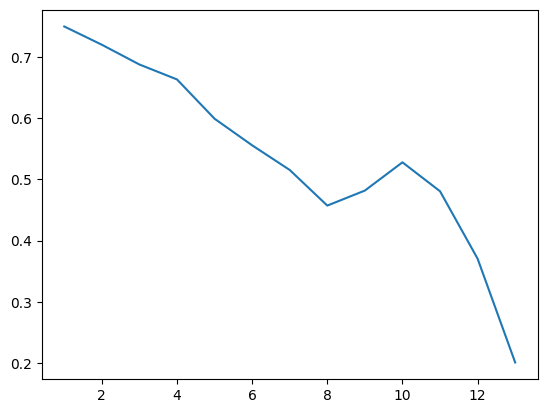

In [96]:
train['nums'] = train['assessmentItemID'].apply(lambda x: x[8:10]).map(int) # 문제 번호 column인 nums 생성
accuracy = train.groupby(['nums'])['answerCode'].mean() # 문제 번호별 정답률인 accuracy
accuracy
plt.plot(accuracy)

- 문항 번호별로 정답률의 차이 존재
- 1번에서 정답률이 가장 높고, 13번에서 정답률이 가장 낮음
- 문항번호가 커질수록 정답률이 감소하는 경향을 보임

# 2. 유저별로 푼 카테고리의 분포가 다른가? 분포상의 차이가 있는가?

In [101]:
train['cat'] = train['assessmentItemID'].apply(lambda x: x[2:3]).map(int) # 대분류 column인 cat 생성

In [102]:
catindex = train.groupby('userID')['cat'].value_counts().index # (userID, cat) multi index 형태의 key
catvalue = train.groupby('userID')['cat'].value_counts().values # [개수] 형태의 value

# multi indx를 풀기 위해서 .get_level_values() 사용
# 각 유저가 어떤 카테고리를 몇 번 만났는가?
user_cat_try = pd.DataFrame({'userID': catindex.get_level_values(0), 'cat' : catindex.get_level_values(1), 'try' : catvalue})
user_cat_try # try는 cat을 만난 홋수

,userID,cat,try
0,0,8,363
1,0,6,346
2,0,2,36
3,1,4,581
4,1,9,352
...,...,...,...
17747,7438,4,5
17748,7440,3,10
17749,7440,5,5
17750,7441,3,5


In [103]:
# 각 유저가 카테고리를 만나 어느 정도의 정답률을 보이는가?
usercatansidx = train.groupby(['userID', 'cat'])['answerCode'].mean().index
usercatansval = train.groupby(['userID', 'cat'])['answerCode'].mean().values
user_cat_ans = pd.DataFrame({'userID': usercatansidx.get_level_values(0), 'cat' : usercatansidx.get_level_values(1), 'ans' : usercatansval})
user_cat_ans # ans는 정답률을 의미하는 column

,userID,cat,ans
0,0,2,0.722222
1,0,6,0.791908
2,0,8,0.468320
3,1,4,0.822719
4,1,9,0.903409
...,...,...,...
17747,7438,8,0.666667
17748,7440,3,0.400000
17749,7440,5,0.400000
17750,7441,3,0.200000


In [104]:
# 위 두 경우를 merge
ucta = pd.merge(left = user_cat_try, right = user_cat_ans, on = ['userID', 'cat'], how = 'left')
ucta # 유저가 만난 cat 수와 그에 따른 정답률
# 실제로 1번 user는 cat 9를 만나 318번 맞고, 34번 틀림

,userID,cat,try,ans
0,0,8,363,0.468320
1,0,6,346,0.791908
2,0,2,36,0.722222
3,1,4,581,0.822719
4,1,9,352,0.903409
...,...,...,...,...
17747,7438,4,5,0.800000
17748,7440,3,10,0.400000
17749,7440,5,5,0.400000
17750,7441,3,5,0.200000


- 유저별 마주친 cat과, 이를 만났을 때의 정답률을 구함
- cat이 높은 문제(어려운 문제로 추정)를 오히려 잘 푸는 학생들도 존재
- 또한 학생들이 만나는 cat의 수가 한정적인 것이 확인됨
- 다만, sequential하게 정답률을 나타내야만 추이를 보고 feature로 사용할 수 있을 듯 (은혜 누님의 tag별 정답률과 같은 맥락)

In [105]:
userID_cat = ucta.groupby(['userID'])['cat'].apply(list).apply(str).to_dict() # user가 만나는 cat의 종류를 str 형태로 뽑음
userid = pd.DataFrame(userID_cat.keys(), columns = ['userID'])
catkind = pd.DataFrame(userID_cat.values(), columns = ['cat_kind']) # cat_kind는 마주친 cat의 종류
ucta_kind = pd.concat([userid, catkind], axis = 1) # userID별 cat_kind dataframe 생성
ucta_kind['cat_len'] = ucta_kind['cat_kind'].apply(lambda x: len(x) / 3).astype(int) # str 형태의 cat_kind를 3으로 나눠 길이에 따라 개수를 뽑는 것이 가능. cat_len column에 저장
ucta_kind # 유저가 경험한 cat 종류와 그 개수

,userID,cat_kind,cat_len
0,0,"[8, 6, 2]",3
1,1,"[4, 9]",2
2,2,"[3, 5]",2
3,5,"[8, 1, 6]",3
4,6,"[3, 4]",2
...,...,...,...
6693,7436,"[3, 5]",2
6694,7437,"[6, 4]",2
6695,7438,"[8, 3, 4]",3
6696,7440,"[3, 5]",2


In [106]:
print(ucta_kind['cat_len'].max()) # 3개
print(ucta_kind['cat_len'].min()) # 1개

print(len(ucta_kind[ucta_kind['cat_len'] == 3])) # 4458명
print(len(ucta_kind[ucta_kind['cat_len'] == 2])) # 2138명
print(len(ucta_kind[ucta_kind['cat_len'] == 1])) # 102명
# 왜 만나는 cat 수가 다른 것일까?

3
1
4458
2138
102


- 각 유저마다 1개부터 3개의 cat을 경험하였음
- 3개 경험 4458명, 2개 경험 2138명, 1개 경험 102명
- 특정한 cat의 조합을 만나는 것일까? 왜 사람마다 만나는 cat의 수가 다를까?

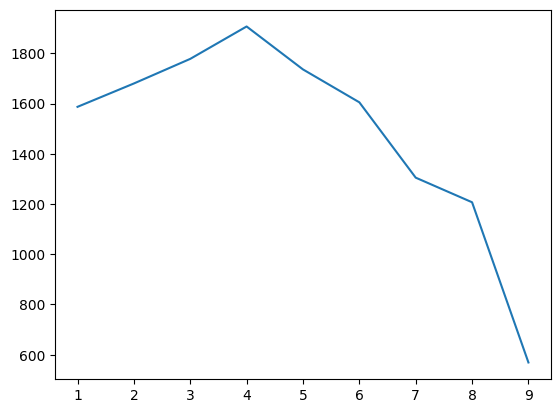

In [107]:
# 9C3의 조합 개수... 모두 보는 것은 일단 보류, 3개 cat을 보는 학생들은 어떤 cat을 가장 많이 볼까 먼저 알아보자
len3_nums = []
for i in range(1, 10):
    len3_nums.append(len(ucta_kind[(ucta_kind['cat_kind'].str.contains(f'{i}')) & (ucta_kind['cat_len'] == 3)]))
plt.plot(range(1,10), len3_nums)

- cat을 3개 만나는 학생들은 4번 cat을 가장 많이 만나고 이후 점차 감소

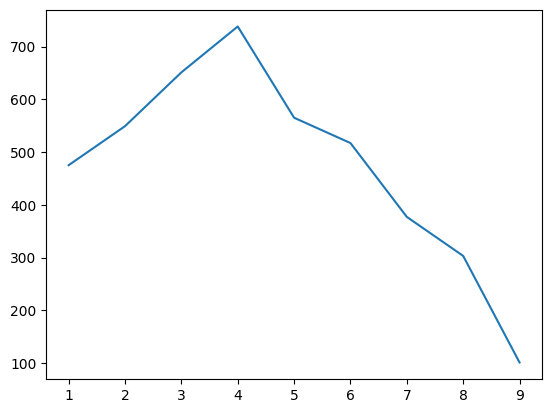

In [108]:
len2_nums = []
for i in range(1, 10):
    len2_nums.append(len(ucta_kind[(ucta_kind['cat_kind'].str.contains(f'{i}')) & (ucta_kind['cat_len'] == 2)]))
plt.plot(range(1,10), len2_nums)

- cat을 2개 만나는 학생들은 4번 cat을 가장 많이 만나고 이후 점차 감소

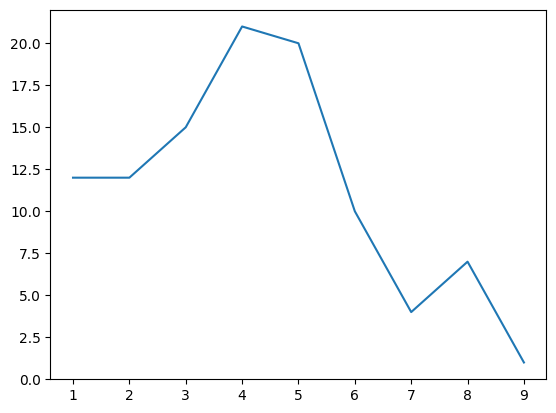

In [109]:
len1_nums = []
for i in range(1, 10):
    len1_nums.append(len(ucta_kind[(ucta_kind['cat_kind'].str.contains(f'{i}')) & (ucta_kind['cat_len'] == 1)]))
plt.plot(range(1,10), len1_nums)

- cat을 1개 만나는 학생들은 4번 cat을 가장 많이 만나고, 이후 감소하다가 8번에서 살짝 반등하였으나 큰 경향은 위 두 그래프와 동일

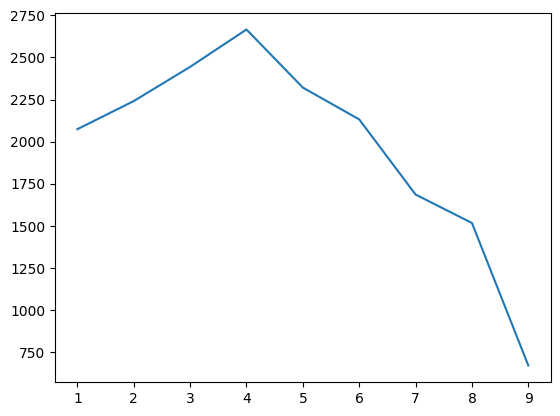

In [110]:
len_all = []
for i in range(1, 10):
    len_all.append(len(ucta_kind[(ucta_kind['cat_kind'].str.contains(f'{i}'))]))
plt.plot(range(1,10), len_all)

- 길이에 무관하게 유저가 만난 cat의 종류를 찍어 봐도 경향성은 동일함

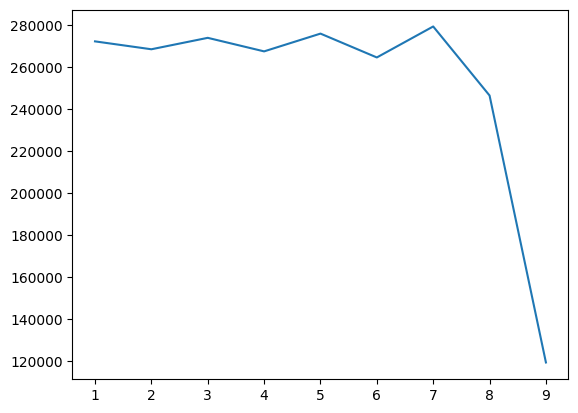

In [111]:
# 전체 train data에서 cat을 센다면?
nums = []
for i in range(1, 10):
    nums.append(len(train[train['cat'] == i]))
plt.plot(range(1,10), nums)

- train에서 cat별 수를 세보면 1-8은 거의 동일, 9번만 매우 낮은 수치임
- 하지만 유저 별로 만난 cat의 종류를 조사하면 4가 가장 높은 산봉우리 모양
- 이는 train data에서 산재되어 있는 cat이 하나로 합쳐지면서 생기는 괴리
   - ex) 1번 유저는 train data에서 cat으로 1, 1, 4, 7, 7, 7, 7 문제를 풀었음 -> 만난 cat은 [1, 4, 7] 3개
- 다만, **4번의 경우에는 웬만한 학생들에게 출제되어 수가 높지만, 다른 번호들(특히 높은 번호들)은 출제되지 않은 경우가 많아서 낮은 경향을 보임**

# 3. 출제되는 cat의 특정 조합만 나오는 것인가?

In [ ]:
##### 이 부분은 필요 없습니다! 오름차순 정렬이 힘들어서 user_cat_ans로 확인을 위해 넣은 코드입니다!
aaa = user_cat_ans.groupby(['userID'])['cat'].apply(list).apply(str).to_dict()
bbb = pd.DataFrame(aaa.keys(), columns = ['userID'])
ccc = pd.DataFrame(aaa.values(), columns = ['cat_kind'])
ddd = pd.concat([bbb, ccc], axis = 1)
ddd['cat_len'] = ddd['cat_kind'].apply(lambda x: len(x) / 3).astype(int)

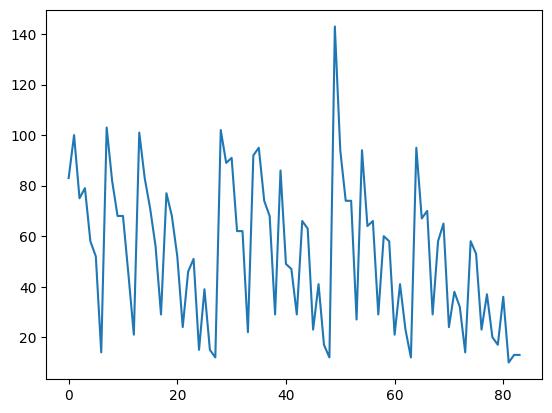

In [121]:
# 3개 cat을 마주친 학생들이 거의 동일한 cat 조합을 마주치는지 알아보자
from itertools import combinations
len3_kind = []
temp = list(combinations([1,2,3,4,5,6,7,8,9], 3))
for x in temp:
    i, j, k = str(x[0]), str(x[1]), str(x[2])
    len3_kind.append(len(ddd[(ddd['cat_kind'].str.contains(f'{i}, {j}, {k}'))]))
plt.plot(range(len(temp)), len3_kind) # 튜플 형태로 축 이름 쓸 수 없어서 번호로 바꿈

- 특정한 조합만 나오는 것은 아니지만, 모든 조합이 고른 분포로 나오는 것도 아님
   - (1,2,3)과 (1,2,4)가 나오는 횟수가 다르다는 의미
   - 잘 안 나오는 조합과 잘 나오는 조합은 확실히 구분이 됨


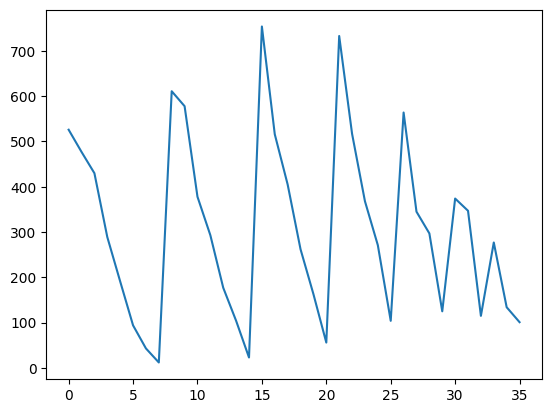

In [123]:
# 2개 cat을 마주친 학생들이 거의 동일한 cat 조합을 마주치는지 알아보자
from itertools import combinations
len2_kind = []
temp2 = list(combinations([1,2,3,4,5,6,7,8,9], 2))
for x in temp2:
    i, j= str(x[0]), str(x[1])
    len2_kind.append(len(ddd[(ddd['cat_kind'].str.contains(f'{i}, {j}'))]))
plt.plot(range(len(temp2)), len2_kind) # 튜플 형태로 축 이름 쓸 수 없어서 번호로 바꿈

- 마찬가지로 특정한 조합만 나오는 것은 아니지만, 모든 조합이 고른 분포로 나오는 것도 아님
   - 잘 나오는 조합과 잘 나오지 않는 조합의 차이가 명확함

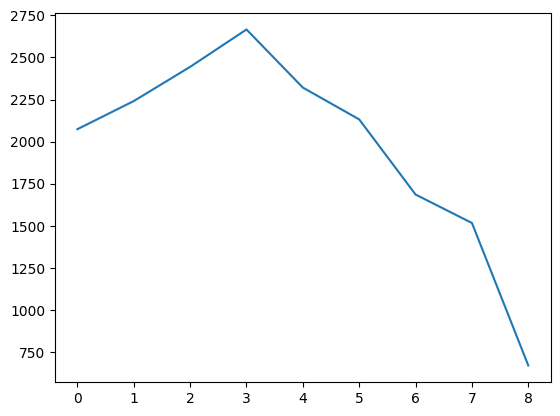

In [125]:
# 1개 cat을 마주친 학생들이 거의 동일한 cat 조합을 마주치는지 알아보자
from itertools import combinations
len1_kind = []
temp3 = list(combinations([1,2,3,4,5,6,7,8,9], 1))
for x in temp3:
    i = str(x[0])
    len1_kind.append(len(ddd[(ddd['cat_kind'].str.contains(f'{i}'))]))
plt.plot(range(len(temp3)), len1_kind) # 튜플 형태로 축 이름 쓸 수 없어서 번호로 바꿈

- 이건 당연히 위에서 이미 그린 그래프와 같음

# 4. 결론
## 1. 전체 유저에 대해 문항 번호별로 정답률의 차이가 있는가?
- 있다. 거의 명확한 선형 관계를 가짐.
- 문항 번호가 높을수록 정답률은 감소
## 2. 유저별로 푼 카테고리의 분포가 다른가? 분포상의 차이가 있는가?
- 다르다. 유저마다 1개 - 3개의 cat만 풀었음.
- 개인으로 봤을 때 cat이 높다고 해서 정답률이 떨어지지 않을 수 있음
- 유저들은 4번 cat을 가장 많이 경헝했고, 4번을 기준으로 유저들의 나머지 cat 경험 횟수는 산봉우리 형태로 감소
## 3. 출제되는 cat의 특정 조합만 나오는 것인가?
- 아니다. 모든 조합이 출제되긴 함.
- 다만, 잘 나오는 조합과 잘 나오지 않는 조합의 차이는 명확함
- 모든 조합이 출제되긴 한다는 점에서, 조합의 패턴이 있다기 보다는 단순히 1-9 cat의 출제 차이에 따른 조합의 등장 차이라고 생각됨(실제로 유저가 경험한 cat 종류와 수는 달랐기 때문)